$$
\rho = \begin{bmatrix}
0 & 0 & 0 & 0 \\
0 & 1 & \nu & 0 \\
0 & \nu^* & 1 & 0 \\
0 & 0 & 0 & 0 
\end{bmatrix}
$$

In [1]:
import itertools
from itertools import cycle
import functools 

import equinox as eqx
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import seaborn as sns
from rich.pretty import pprint


from squint.circuit import Circuit
from squint.ops.fock import BeamSplitter, FockState, Phase, WeakCoherentSource
from squint.utils import partition_op, print_nonzero_entries

jax.config.update("jax_enable_x64", True)

In [12]:
cut = 2  # the photon number truncation for the simulation
circuit = Circuit(backend="nonunitary")

# note: `wires` is a spatial mode in this context (in other contexts this can be a information carrying unit, e.g., a qubit/qudit)
# we add in the stellar photon, which is in an even superposition of spatial modes 0 and 2 (left and right telescopes)
circuit.add(
    WeakCoherentSource(
        wires=(
            0,
            2,
        ),
        g=1.0,
        phi=0.2,
    ),
    'star'
)

# circuit.ops['star'](cut)
# # we add the resources photon, which is in an even superposition of spatial modes 1 and 3
circuit.add(
    FockState(
        wires=(
            1,
            3,
        ),
        n=[(1 / jnp.sqrt(2).item(), (1, 0)), (1 / jnp.sqrt(2).item(), (0, 1))],
    )
)

# we add the linear optical circuit at each telescope (by default this is a 50-50 beamsplitter)
circuit.add(
    BeamSplitter(
        wires=(
            0,
            1,
        ),
    ),
    "bs_left"
)
circuit.add(
    BeamSplitter(
        wires=(
            2,
            3,
        ),
    )
)
pprint(circuit)

# we split out the params which can be varied (in this example, it is just the "phase" phi value), and all the static parameters (wires, etc.)
# params, static = partition_op(circuit, "star")
params, static = eqx.partition(circuit, eqx.is_inexact_array)


# next we compile the circuit description into function calls, which compute, e.g., the quantum state, probabilities, partial derivates of the quantum state, and partial derivatives of the probabilities
sim = circuit.compile(params, static, dim=cut, optimize="greedy").jit()

# path = circuit.path(dim=cut, optimize="greedy", backend="nonunitary")

# we define a function which indexes in the circuit object, and all other pytrees computed from it, a specific value. this will be necessary to access, e.g., the gradients
get = lambda pytree: jnp.array([pytree.ops["star"].phi, pytree.ops["star"].g])

Circuit(
  ops={
│   'star':
│   WeakCoherentSource(wires=(0, 2), g=weak_f64[], phi=weak_f64[]),
│   1:
│   FockState(
│     wires=(1, 3),
│     n=[(0.7071067811865475, (1, 0)), (0.7071067811865475, (0, 1))]
│   ),
│   'bs_left':
│   BeamSplitter(wires=(0, 1), r=weak_f64[]),
│   3:
│   BeamSplitter(wires=(2, 3), r=weak_f64[])
  },
  _backend='nonunitary'
)

In [13]:
circuit.evaluate(dim=cut)
circuit.path(dim=cut, optimize="greedy")

([(0, 2), (0, 1), (4, 5), (0, 2), (0, 1), (1, 2), (0, 1)],
   Complete contraction:  ac,eg,aiek,cmgo,bd,fh,bjfl,dnhp->ikmojlnp
          Naive scaling:  16
      Optimized scaling:  8
       Naive FLOP count:  5.243e+5
   Optimized FLOP count:  7.680e+2
    Theoretical speedup:  6.827e+2
   Largest intermediate:  2.560e+2 elements
 --------------------------------------------------------------------------------
 scaling        BLAS                current                             remaining
 --------------------------------------------------------------------------------
    5           GEMM          aiek,ac->iekc    eg,cmgo,bd,fh,bjfl,dnhp,iekc->ikmojlnp
    5           TDOT          cmgo,eg->cmoe    bd,fh,bjfl,dnhp,iekc,cmoe->ikmojlnp
    6           TDOT        cmoe,iekc->moik        bd,fh,bjfl,dnhp,moik->ikmojlnp
    5           GEMM          bjfl,bd->jfld           fh,dnhp,moik,jfld->ikmojlnp
    5           TDOT          dnhp,fh->dnpf              moik,jfld,dnpf->ikmojlnp
    6 

In [14]:
ket = sim.amplitudes.forward(params)
prob = sim.prob.forward(params)
grad = sim.prob.grad(params)

# print_nonzero_entries(prob)

In [15]:
# this can also be performed from the `sim` object
cfim = sim.prob.cfim(get, params)
print(f"The classical Fisher information is\n", cfim)

The classical Fisher information is
 [[4.99999864e-01 3.50068614e-08]
 [3.50068614e-08 1.50000002e+00]]


In [23]:
rs = jnp.linspace(-jnp.pi/2, jnp.pi/2, 50)
phis = jnp.linspace(-jnp.pi/2, jnp.pi/2, 50)

def cfim_sweep_r(r, params, get):
    params = eqx.tree_at(lambda pytree: pytree.ops["bs_left"].r, params, r)
    return sim.prob.cfim(get, params)
   
def prob_sweep_phi(phi, params):
    params = eqx.tree_at(lambda pytree: pytree.ops["star"].phi, params, phi)
    return sim.prob.forward(params) 
    
cfims = jax.lax.map(functools.partial(cfim_sweep_r, params=params, get=get), rs)
probs = jax.lax.map(functools.partial(prob_sweep_phi, params=params), phis)

[Text(0.5, 0, 'Phase, $\\varphi$'),
 Text(0, 0.5, 'Probability, $p(\\mathbf{x} | \\varphi)$')]

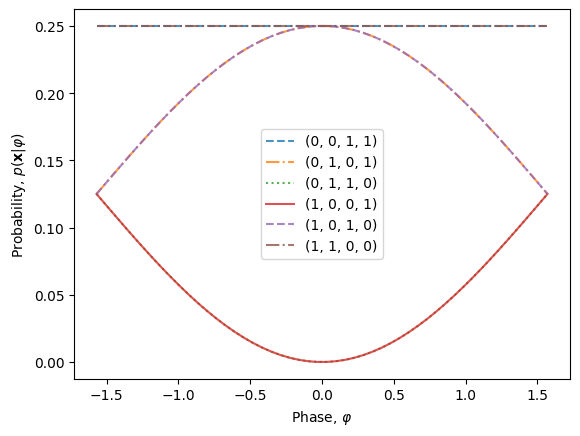

In [24]:
colors = cycle(sns.color_palette(n_colors=jnp.prod(jnp.array(probs.shape[1:]))))
styles = cycle(["--", "-.", ":", "solid", "dashed", "dashdot", "dotted"])
fig, ax = plt.subplots()
for i, idx in enumerate(
    itertools.product(*[list(range(ell)) for ell in probs.shape[1:]])
):
    if jnp.mean(probs[:, *idx]) < 1e-6:
        continue
    label = f"{idx}" if jnp.mean(probs[:, *idx]) > 1e-6 else None
    # print(label, jnp.mean(probs[:, *idx]))
    ax.plot(
        phis,
        probs[:, *idx],
        label=label,
        color=next(colors),
        ls=next(styles),
        alpha=0.8,
    )
ax.legend()
ax.set(xlabel=r"Phase, $\varphi$", ylabel=r"Probability, $p(\mathbf{x} | \varphi)$")

[Text(0.5, 0, 'BS coeff., $r/\\pi$'),
 Text(0, 0.5, 'CFIM element, $\\mathcal{I}_{i,j}^C$')]

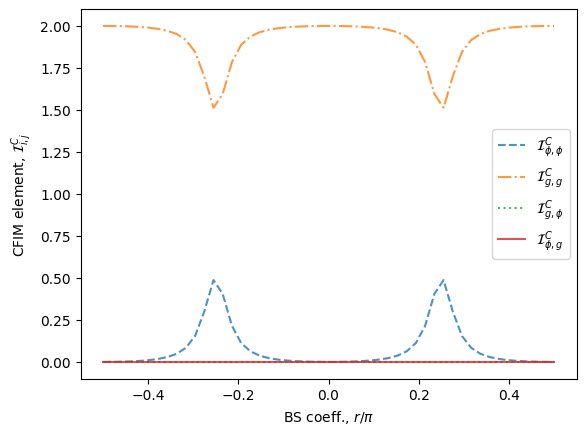

In [27]:
colors = cycle(sns.color_palette(n_colors=jnp.prod(jnp.array(probs.shape[1:]))))
styles = cycle(["--", "-.", ":", "solid", "dashed", "dashdot", "dotted"])
fig, ax = plt.subplots()
ax.plot(rs/jnp.pi, cfims[:, 0, 0], label=r'$\mathcal{I}_{\phi,\phi}^C$', color=next(colors), ls=next(styles), alpha=0.8,)
ax.plot(rs/jnp.pi, cfims[:, 1, 1], label=r'$\mathcal{I}_{g, g}^C$', color=next(colors), ls=next(styles), alpha=0.8,)
ax.plot(rs/jnp.pi, cfims[:, 0, 1], label=r'$\mathcal{I}_{g, \phi}^C$', color=next(colors), ls=next(styles), alpha=0.8,)
ax.plot(rs/jnp.pi, cfims[:, 1, 0], label=r'$\mathcal{I}_{\phi, g}^C$', color=next(colors), ls=next(styles), alpha=0.8,)

ax.legend()
ax.set(xlabel=r"BS coeff., $r/\pi$", ylabel=r"CFIM element, $\mathcal{I}_{i,j}^C$")